# Video segmentation with SAM 2

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import pandas as pd
import IPython

In [3]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def df_set(df, image_name, key, value):
    df.at[df.index[df['image_name'] == image_name][0], key] = value

def df_get(df, image_name, key):
    return df.at[df.index[df['image_name'] == image_name][0], key]

### Set up each split

In [5]:
root_dir = "/home/vansh/Desktop/labelled_data"

In [6]:
video_paths = []

for vid_name in os.listdir(root_dir):
    vid_path = os.path.join(root_dir, vid_name)
    top_path = os.path.join(vid_path, "top")
    bottom_path = os.path.join(vid_path, "bottom")

    for split_name in os.listdir(top_path):
        split_path = os.path.join(top_path, split_name)
        video_paths.append(split_path)
    
    for split_name in os.listdir(bottom_path):
        split_path = os.path.join(bottom_path, split_name)
        video_paths.append(split_path)

print(f"Found {len(video_paths)} videos (splits)")

Found 45 videos (splits)


In [21]:
for vid_path in video_paths:
    images = os.listdir(vid_path)
    if "data.csv" in images:
        print(f"WARN - {vid_path} already has data.csv")
        continue
    data = {'image_name' : images}
    df = pd.DataFrame(data)
    df.to_csv(os.path.join(vid_path, "data.csv"), index=False)

WARN - /home/vansh/Desktop/labelled_data/S011-20220612-160000-170000/top/split_1 already has data.csv
WARN - /home/vansh/Desktop/labelled_data/S011-20220612-160000-170000/top/split_2 already has data.csv
WARN - /home/vansh/Desktop/labelled_data/S011-20220612-160000-170000/top/split_0 already has data.csv
WARN - /home/vansh/Desktop/labelled_data/S011-20220612-160000-170000/top/split_3 already has data.csv
WARN - /home/vansh/Desktop/labelled_data/S011-20220612-160000-170000/bottom/split_0 already has data.csv
WARN - /home/vansh/Desktop/labelled_data/S012-20220916-090000-100000-002/top/split_0 already has data.csv
WARN - /home/vansh/Desktop/labelled_data/S012-20220916-090000-100000-002/bottom/split_0 already has data.csv
WARN - /home/vansh/Desktop/labelled_data/S010-20220610-134339-152819-008/top/split_0 already has data.csv
WARN - /home/vansh/Desktop/labelled_data/S010-20220610-134339-152819-008/bottom/split_0 already has data.csv
WARN - /home/vansh/Desktop/labelled_data/S010-20220613-19

### Loading the SAM 2 video predictor

In [8]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

/home/vansh/Documents/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [74]:
i = 0
video_dir = "./videos/to_process"


while i < len(video_paths):
    if os.path.exists(video_dir):
        shutil.rmtree(video_dir)
    os.makedirs(video_dir)

    path = video_paths[i]
    frame_names = [
        p for p in os.listdir(path)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
    frame_path = os.path.join(path, frame_names[0])
    first_frame = Image.open(frame_path)

    shutil.copy(frame_path, video_dir)
    inference_state = predictor.init_state(video_path=video_dir)
    predictor.reset_state(inference_state)

    IPython.display.clear_output()
    plt.clf()
    

    plt.figure(figsize=(9, 6))
    plt.imshow(first_frame)

    df = pd.read_csv(os.path.join(path, "data.csv"))
    if 'click_point' in df.columns:
        df.drop(columns=['click_point'])
    if 'click_x' not in df.columns:
        df['click_x'] = -1.0
    if 'click_y' not in df.columns:
        df['click_y'] = -1.0
    if df_get(df, frame_names[0], 'click_x') != -1.0:
        x = df_get(df, frame_names[0], 'click_x')
        y = df_get(df, frame_names[0], 'click_y')
        points = np.array([[x, y]], dtype=np.float32)
        labels = np.array([1], np.int32)
        show_points(points, labels, plt.gca())

        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=0,
            obj_id=1,
            points=points,
            labels=labels,
        )
        show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

        plt.show()
        inp = input("confirm y/n?")
        if inp == "y":
            i += 1
            continue
    else:
        plt.show()

    inp = input("Enter x y")
    x, y = inp.split()
    x, y = float(x), float(y)

    IPython.display.clear_output()
    plt.clf()

    plt.figure(figsize=(9, 6))
    plt.imshow(first_frame)

    points = np.array([[x, y]], dtype=np.float32)
    labels = np.array([1], np.int32)
    show_points(points, labels, plt.gca())

    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=0,
            obj_id=1,
            points=points,
            labels=labels,
        )
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

    plt.show()

    inp = input("confirm y/n?")

    IPython.display.clear_output()
    plt.clf()

    if inp == "y":
        df_set(df, frame_names[0], 'click_x', x)
        df_set(df, frame_names[0], 'click_y', y)
        df.to_csv(os.path.join(path, "data.csv"), index=False)
        i += 1

<Figure size 640x480 with 0 Axes>

In [9]:
video_dir = "./videos/to_process"
batch_size = 100
reach = 5

root_path = video_paths[0]
frame_names = [
    p for p in os.listdir(root_path)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
df = pd.read_csv(os.path.join(root_path, "data.csv"))

if 'rand_x_1' not in df.columns:
    df['rand_x_1'] = -1.0
if 'rand_y_1' not in df.columns:
    df['rand_y_1'] = -1.0
if 'rand_x_2' not in df.columns:
    df['rand_x_2'] = -1.0
if 'rand_y_2' not in df.columns:
    df['rand_y_2'] = -1.0
if 'rand_x_3' not in df.columns:
    df['rand_x_3'] = -1.0
if 'rand_y_3' not in df.columns:
    df['rand_y_3'] = -1.0
if 'rand_x_4' not in df.columns:
    df['rand_x_4'] = -1.0
if 'rand_y_4' not in df.columns:
    df['rand_y_4'] = -1.0

if 'min_x' not in df.columns:
    df['min_x'] = -1.0
if 'min_y' not in df.columns:
    df['min_y'] = -1.0
if 'max_x' not in df.columns:
    df['max_x'] = -1.0
if 'max_y' not in df.columns:
    df['max_y'] = -1.0

for frame_idx in range(0, len(frame_names), batch_size):
    if os.path.exists(video_dir):
        shutil.rmtree(video_dir)
    os.makedirs(video_dir)

    curr_frame_names = frame_names[frame_idx:frame_idx + batch_size + reach]
    print(len(curr_frame_names))
    for frame_name in curr_frame_names:
        frame_path = os.path.join(root_path, frame_name)
        shutil.copy(frame_path, video_dir)
    torch.cuda.empty_cache()
    inference_state = predictor.init_state(video_path=video_dir)
    predictor.reset_state(inference_state)

    if frame_idx == 0:
        init_click_x = df_get(df, curr_frame_names[0], 'click_x')
        init_click_y = df_get(df, curr_frame_names[0], 'click_y')
        assert init_click_x != -1.0
        assert init_click_y != -1.0

        points = np.array([[init_click_x, init_click_y]], dtype=np.float32)
        labels = np.array([1], np.int32)

        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=0,
            obj_id=1,
            points=points,
            labels=labels,
        )
    else:
        for sub_frame_no in range(reach):
            for i in range(1, 5):
                rand_x = df_get(df, curr_frame_names[sub_frame_no], f'rand_x_{i}')
                rand_y = df_get(df, curr_frame_names[sub_frame_no], f'rand_y_{i}')
                if rand_x != -1.0 and rand_y != -1.0:
                    points = np.array([[rand_x, rand_y]], dtype=np.float32)
                    labels = np.array([1], np.int32)

                    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                        inference_state=inference_state,
                        frame_idx=sub_frame_no,
                        obj_id=1,
                        points=points,
                        labels=labels,
                    )
                else:
                    print(f"WARN - {curr_frame_names[sub_frame_no]} does not have random points")
    video_segments = {} 
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    out_obj_id = 1
    for frame_idx in range(0, len(curr_frame_names)):
        frame_name = curr_frame_names[frame_idx]
        out_mask = video_segments[out_frame_idx][out_obj_id][0]

        y, x = np.nonzero(out_mask)
        if len(y) == 0:
            continue
        y_min, x_min = np.min(y), np.min(x)
        y_max, x_max = np.max(y), np.max(x)
        df_set(df, frame_name, 'min_x', x_min)
        df_set(df, frame_name, 'min_y', y_min)
        df_set(df, frame_name, 'max_x', x_max)
        df_set(df, frame_name, 'max_y', y_max)
        
        for i in range(1, 5):
            rand = np.random.randint(len(y))
            df_set(df, frame_name, f'rand_x_{i}', x[rand])
            df_set(df, frame_name, f'rand_y_{i}', y[rand])
df.to_csv(os.path.join(root_path, "data.csv"), index=False)

105


frame loading (JPEG): 100%|██████████| 105/105 [00:02<00:00, 35.92it/s]
/home/vansh/Documents/segment-anything-2/sam2/sam2_video_predictor.py:869: UserWarning: cannot import name '_C' from 'sam2' (/home/vansh/Documents/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. Consider building SAM 2 with CUDA extension to enable post-processing (see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 105/105 [00:26<00:00,  3.98it/s]


105


propagate in video: 100%|██████████| 105/105 [00:31<00:00,  3.30it/s]


105


propagate in video: 100%|██████████| 105/105 [00:31<00:00,  3.30it/s]


105


propagate in video: 100%|██████████| 105/105 [00:32<00:00,  3.26it/s]


105


propagate in video: 100%|██████████| 105/105 [00:32<00:00,  3.27it/s]


105


propagate in video:  10%|█         | 11/105 [00:02<00:17,  5.43it/s]


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


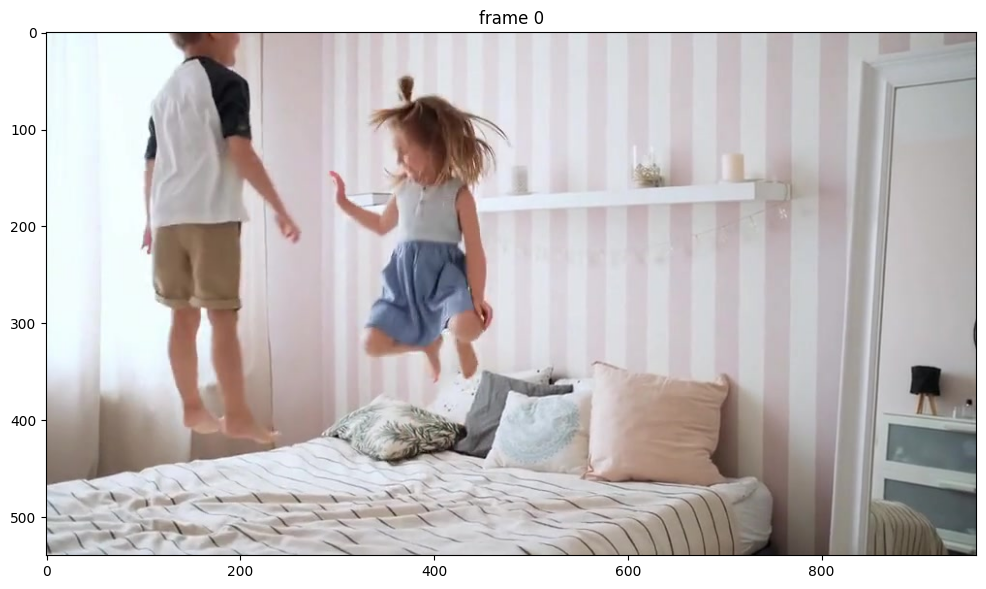

In [ ]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
source_dir = "./videos/test"
video_dir = source_dir

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(source_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(source_dir, frame_names[frame_idx])))

In addition to using clicks as inputs, SAM 2 also supports segmenting and tracking objects in a video via **bounding boxes**.

In the example below, we segment the child on the right using a **box prompt** of (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) on frame 0 as input into the `add_new_points_or_box` API.

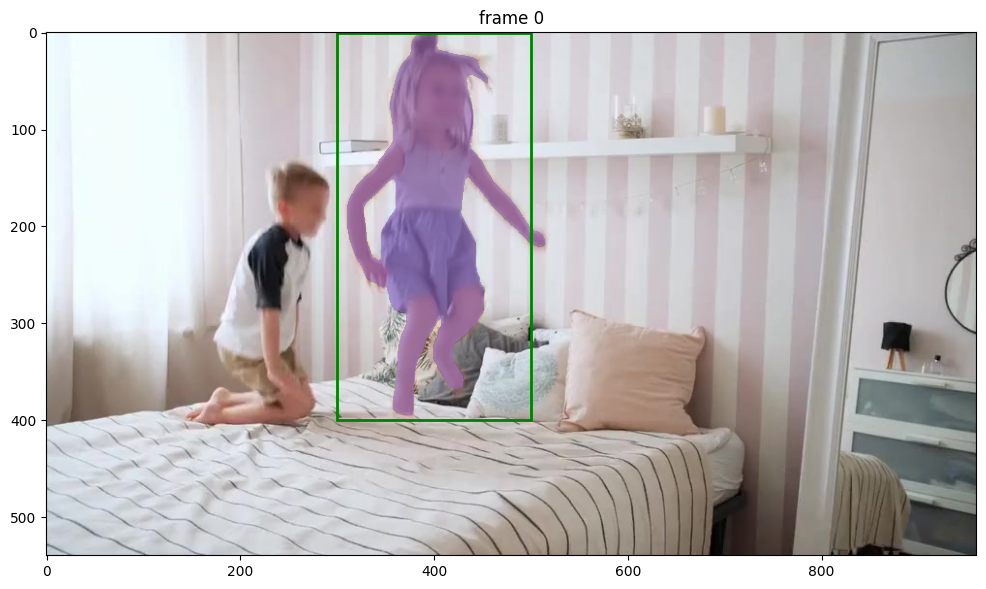

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([300, 0, 500, 400], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

Here, SAM 2 gets a pretty good segmentation mask of the entire child, even though the input bounding box is not perfectly tight around the object.

Similar to the previous example, if the returned mask from is not perfect when using a box prompt, we can also further **refine** the output using positive or negative clicks. To illustrate this, here we make a **positive click** at (x, y) = (460, 60) with label `1` to expand the segment around the child's hair.

Note: to refine the segmentation mask from a box prompt, we need to send **both the original box input and all subsequent refinement clicks and their labels** when calling `add_new_points_or_box`.

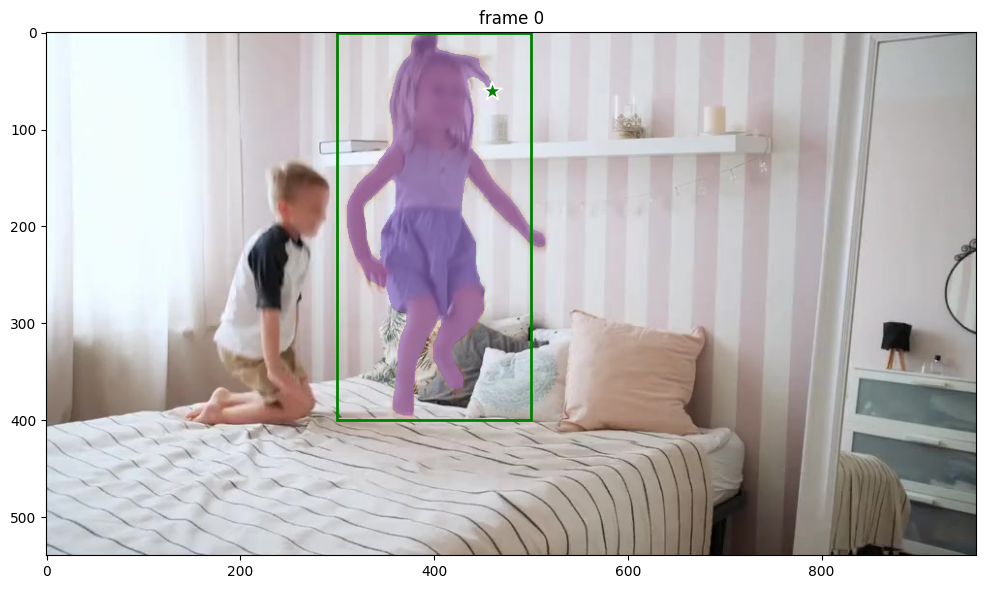

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (460, 60) to refine the mask
points = np.array([[460, 60]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
# note that we also need to send the original box input along with
# the new refinement click together into `add_new_points_or_box`
box = np.array([300, 0, 500, 400], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

Then, to get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

propagate in video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.05it/s]


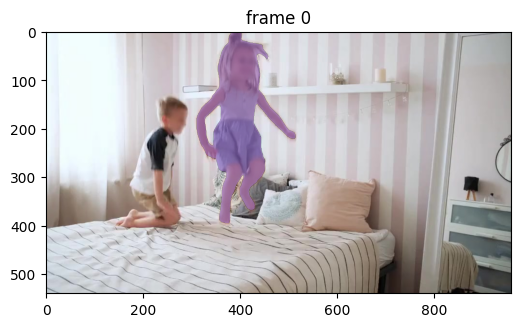

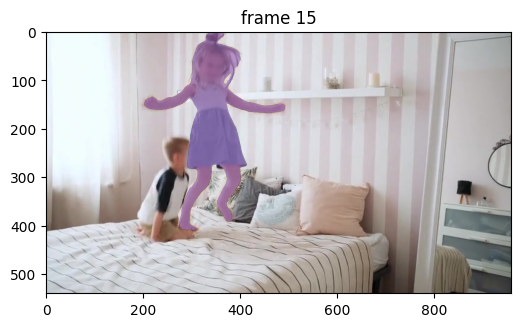

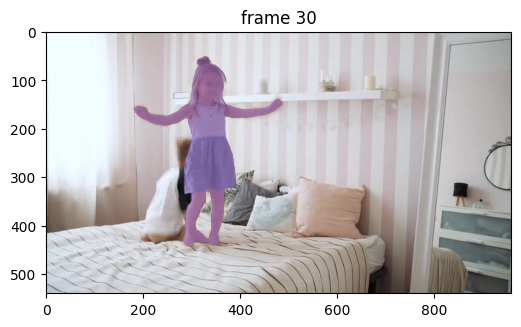

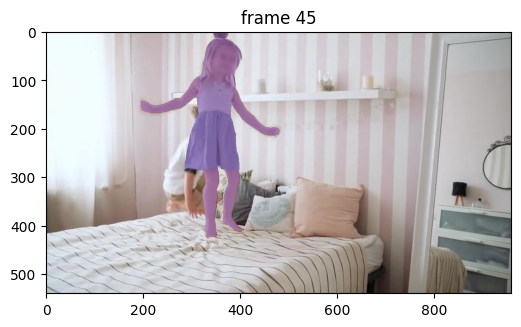

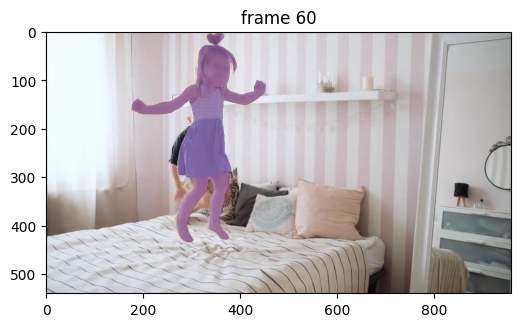

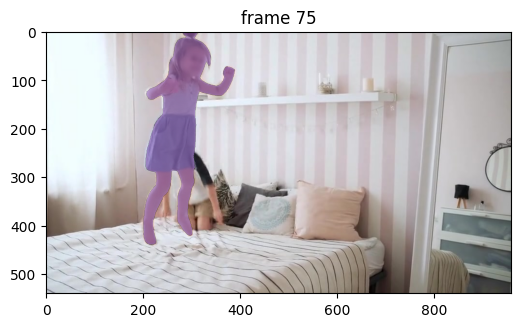

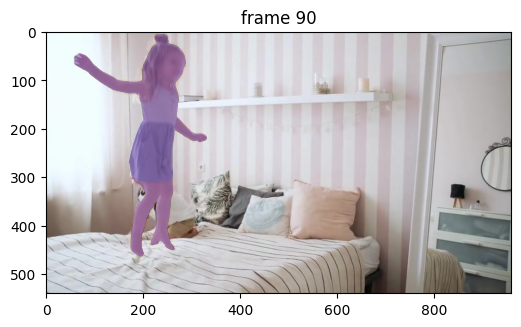

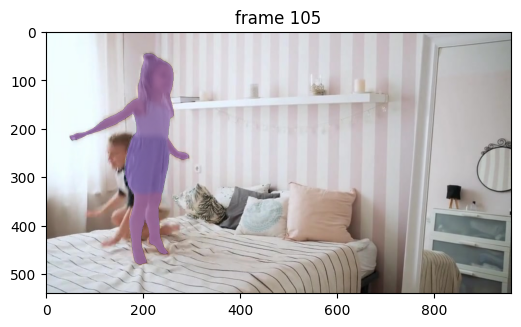

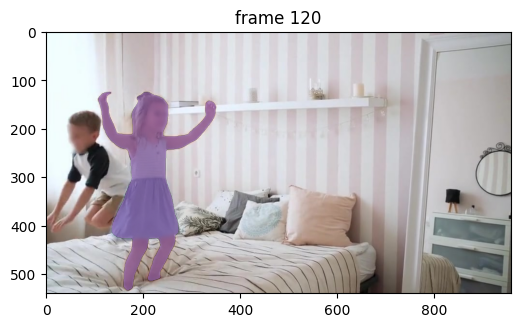

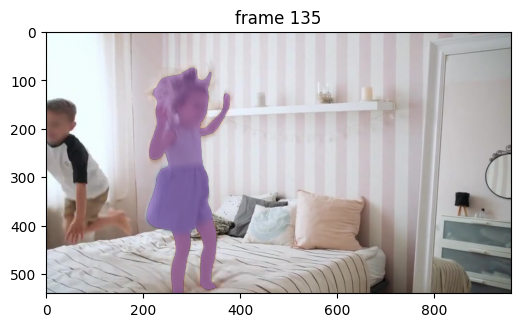

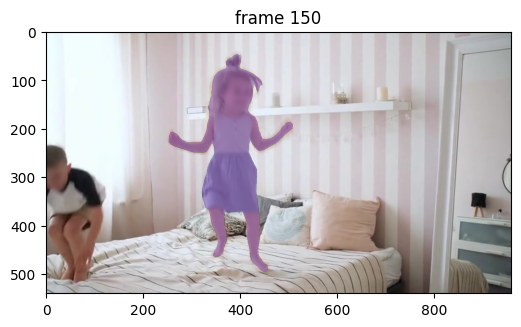

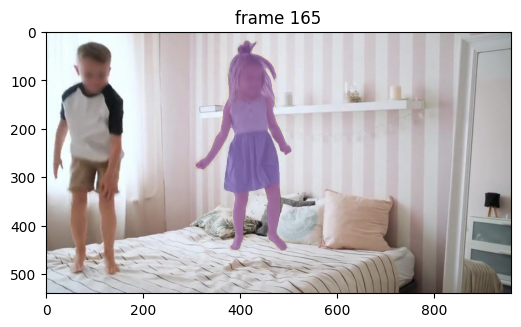

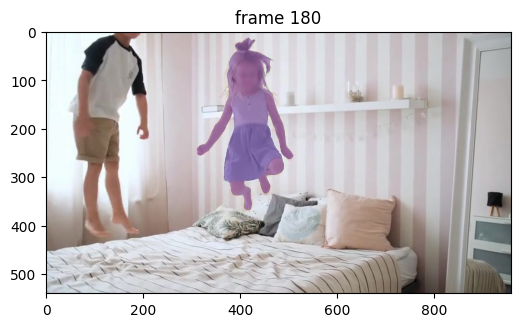

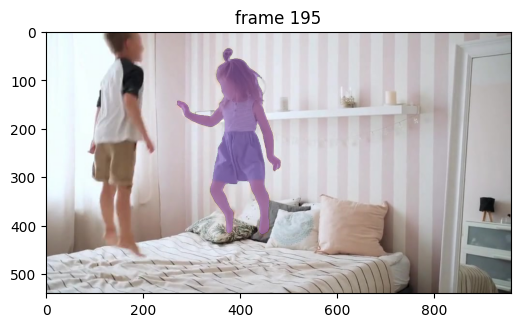

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 15
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)